In [404]:
from itertools import combinations_with_replacement
from collections import Counter
import pandas as pd
import numpy as np
from math import factorial

##############################################
# Portefeuille ou indice
##############################################

def portfolio(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1, indice = False):
    
    if indice == False:
        # Espérance des Small Cap
        E_R_sc_adjusted = smallcap_ptf(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[0]

        # Espérance des Big Cap 
        E_R_bc_total = bigcap_ptf(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[0]

        # Espérance du portefeuille
        E_R = E_R_sc_adjusted + E_R_bc_total

        # Variance du small cap
        Var_R_sc_adjusted = smallcap_ptf(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[1]

        # Variance du big cap
        Var_R_bc_total = bigcap_ptf(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[1]
        
        # Espérance des Small Cap sans ajustement
        E_R_sc_ptf_total = smallcap_ptf(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[2]

        E_WY = esperance_WY(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)

        # Covariance
        Cov_R_sc_bc = E_R_sc_ptf_total * E_WY - E_R_sc_adjusted * E_R_bc_total

        # Variance du portefeuille
        Var_R = Var_R_sc_adjusted + Var_R_bc_total + 2 * Cov_R_sc_bc
    
    else:
        # Espérance des Small Cap
        E_R_sc_adjusted = smallcap_indice(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[0]

        # Espérance des Big Cap 
        E_R_bc_total = bigcap_indice(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[0]

        # Espérance du portefeuille
        E_R = E_R_sc_adjusted + E_R_bc_total

        # Variance du small cap
        Var_R_sc_adjusted = smallcap_indice(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[1]

        # Variance du big cap
        Var_R_bc_total = bigcap_indice(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=x)[1]

        # Variance du portefeuille
        Var_R = Var_R_sc_adjusted + Var_R_bc_total
        
    return E_R, Var_R

##############################################
# Delta
##############################################

def delta(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1, Precision = False):
    
    Esperance_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
    Variance_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[1]

    Esperance_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[0]
    Variance_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[1]

    Cov = covariance_RptfRindice(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, Precision = Precision)

    Esperance = Esperance_ptf - Esperance_indice
    Var = Variance_ptf + Variance_indice - 2 * Cov
    
    return Esperance, Var

##############################################
# Poches Portefeuille
##############################################

def bigcap_ptf(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    # Espérance des Big Cap 
    E_R_bc_correct = ph * (ppc * (w_bigcap + x) + (1 - ppc) * (w_bigcap - y)) * rh  # Correct prediction outcomes
    E_R_bc_incorrect = (1 - ph) * (ppc * (w_bigcap - y) + (1 - ppc) * (w_bigcap + x)) * rb  # Incorrect prediction outcomes
    E_R_bc = (E_R_bc_correct + E_R_bc_incorrect)
    E_R_bc_total = E_R_bc * n_bigcap
    

    # Variance des Big Cap
    Var_R_bc = (ph * (rh)**2 * (ppc * (w_bigcap + x)**2 + (1 - ppc) * (w_bigcap - y)**2) + (1 - ph) * (rb)**2 * (ppc * (w_bigcap - y)**2 + (1 - ppc) * (w_bigcap + x)**2)) - E_R_bc**2
    Var_R_bc_total = Var_R_bc * n_bigcap

    return E_R_bc_total, Var_R_bc_total

def smallcap_ptf(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    # Espérance des Small Cap
    E_R_sc_ptf_correct = ((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc))) * rh
    E_R_sc_ptf_incorrect = (1 - ((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc)))) * rb 
    E_R_sc_ptf_total = (E_R_sc_ptf_correct + E_R_sc_ptf_incorrect) #* 1/n_smallcap_ptf * n_smallcap_ptf
    
    # Variance des Small Cap
    #Var_X_sc_ptf = ((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc))) * ((rh - E_X_sc_ptf_total) ** 2) + (1 - ((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc)))) * ((rb - E_X_sc_ptf_total) ** 2)
    Var_R_sc_ptf = ((((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc))) * ((rh) ** 2) + (1 - ((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc)))) * ((rb) ** 2)) - E_R_sc_ptf_total**2)
    Var_R_sc_ptf_N = Var_R_sc_ptf / (N_ptf - n_bigcap)

    # Espérance de l'ajustement
    E_X_ajustement = (ph * ppc + (1 - ph) * (1 - ppc)) * x - (ph * (1 - ppc) + (1 - ph) * ppc) * y
    E_W_sc = 1 - n_bigcap * (w_bigcap + E_X_ajustement)

    # Variance de l'ajustement
    Var_X_ajustement = (ph * ppc + (1 - ph) * (1 - ppc)) * (x - E_X_ajustement)**2 + (ph * (1 - ppc) + (1 - ph) * ppc) * (-y - E_X_ajustement)**2
    Var_W_sc = Var_X_ajustement * n_bigcap

    # Espérance ajustée pour les rendements "Small Cap" en prenant en compte l'ajustement de poids
    E_R_sc_ptf_adj = E_R_sc_ptf_total * E_W_sc

    # Variance ajustée pour les rendements "Small Cap" en prenant en compte l'ajustement de poids
    Var_R_sc_ptf_adj = Var_R_sc_ptf_N * E_W_sc**2 + Var_W_sc * E_R_sc_ptf_total**2 + Var_W_sc * Var_R_sc_ptf_N

    return E_R_sc_ptf_adj, Var_R_sc_ptf_adj, E_R_sc_ptf_total

def ajustement(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    # Espérance de l'ajustement
    E_x_ajustement = (ph * ppc + (1 - ph) * (1 - ppc)) * x - (ph * (1 - ppc) + (1 - ph) * ppc) * y
    E_x_total = E_x_ajustement * n_bigcap

    # Variance de l'ajustement
    Var_x_ajustement = (ph * ppc + (1 - ph) * (1 - ppc)) * (x - E_x_ajustement)**2 + (ph * (1 - ppc) + (1 - ph) * ppc) * (-y - E_x_ajustement)**2
    Var_x_ajustement_total = Var_x_ajustement * n_bigcap
    return E_x_ajustement, E_x_total, Var_x_ajustement, Var_x_ajustement_total

def esperance_W(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    
    E_Adj = ajustement(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
    return 1 - n_bigcap * (w_bigcap + E_Adj)
    
    
##############################################
# Poches Indice
##############################################

def bigcap_indice(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    # Espérance des Big Cap 
    E_R_bc_correct = ph * w_bigcap * rh  # Correct prediction outcomes
    E_R_bc_incorrect = (1 - ph) * w_bigcap * rb  # Incorrect prediction outcomes
    E_R_bc = (E_R_bc_correct + E_R_bc_incorrect)
    E_R_bc_total = E_R_bc * n_bigcap
    

    # Variance des Big Cap
    Var_R_bc = ph * w_bigcap**2 * rh**2 + (1 - ph) * w_bigcap**2 * rb**2 - E_R_bc**2
    Var_R_bc_total = Var_R_bc * n_bigcap

    return E_R_bc_total, Var_R_bc_total

def smallcap_indice(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    
    # Espérance des Small Cap de l'indice
    E_R_sc_correct_indice = ph * rh
    E_R_sc_incorrect_indice = (1 - ph) * rb
    E_R_sc_total_indice = (E_R_sc_correct_indice + E_R_sc_incorrect_indice)
    E_R_sc_total_indice_adj = E_R_sc_total_indice * (1 - n_bigcap * w_bigcap)

    # Variance des Small Cap de l'indice
    Var_R_sc_indice = (ph * (rh)**2 + (1 - ph) * (rb)**2) - E_R_sc_total_indice**2
    Var_R_sc_indice_total = Var_R_sc_indice / (N_indice - n_bigcap)
    Var_R_sc_indice_adj = Var_R_sc_indice_total * (1 - n_bigcap * w_bigcap)**2

    return E_R_sc_total_indice_adj, Var_R_sc_indice_adj

##############################################
# Espérance pour Covariances
##############################################

def calculate_permutations(combination):
    element_counts = Counter(combination).values()
    return factorial(len(combination)) // np.prod([factorial(count) for count in element_counts])


def esperance_WB(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    
    elements = {
        'rhx': [rh * w_bigcap, ph * ppc, 'x'],
        'rhy': [rh * w_bigcap, ph * (1 - ppc), 'y'],
        'rby': [rb * w_bigcap, (1 - ph) * ppc, 'y'],
        'rbx': [rb * w_bigcap, (1 - ph) * (1 - ppc), 'x'],
    }

    combinations = list(combinations_with_replacement(elements.keys(), n_bigcap))

    return sum(
        calculate_permutations(combination) * np.prod([elements[element][1] for element in combination]) *
        (sum([elements[element][0] for element in combination]) * (1 - n_bigcap * w_bigcap - 
        sum([elements[element][2] == 'x' for element in combination]) * x + 
        sum([elements[element][2] == 'y' for element in combination]) * y))
        for combination in combinations
    )

def esperance_YB(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    elements = {
        'rhx': [rh * (w_bigcap + x), rh * w_bigcap, ph * ppc, 'x'],
        'rhy': [rh * (w_bigcap - y), rh * w_bigcap, ph * (1 - ppc), 'y'],
        'rby': [rb * (w_bigcap - y), rb * w_bigcap, (1 - ph) * ppc, 'y'],
        'rbx': [rb * (w_bigcap + x), rb * w_bigcap, (1 - ph) * (1 - ppc), 'x'],
    }
    
    combinations = list(combinations_with_replacement(elements.keys(), n_bigcap))

    return sum(
        calculate_permutations(combination) * np.prod([elements[element][2] for element in combination]) *
        (sum([elements[element][0] for element in combination]) * sum([elements[element][1] for element in combination]))
        for combination in combinations
    )

def esperance_WY(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    elements = {
        'rhx': [rh * (w_bigcap + x), ph * ppc, 'x'],
        'rhy': [rh * (w_bigcap - y), ph * (1 - ppc), 'y'],
        'rby': [rb * (w_bigcap - y), (1 - ph) * ppc, 'y'],
        'rbx': [rb * (w_bigcap + x), (1 - ph) * (1 - ppc), 'x'],
    }

    combinations = list(combinations_with_replacement(elements.keys(), n_bigcap))

    return sum(
        calculate_permutations(combination) * np.prod([elements[element][1] for element in combination]) *
        (sum([elements[element][0] for element in combination]) * (1 - n_bigcap * w_bigcap - 
        sum([elements[element][2] == 'x' for element in combination]) * x + 
        sum([elements[element][2] == 'y' for element in combination]) * y))
        for combination in combinations
    )

def simulate_XS(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05,y=0.1, Precision = 10000):
    n_smallcap_indice = N_indice - n_bigcap
    exposition_smallcap_indice = 1 - n_bigcap * w_bigcap
    w_smallcap_indice = exposition_smallcap_indice / n_smallcap_indice
    n_smallcap_ptf = N_ptf - n_bigcap

    results = []

    for _ in range(Precision):
        returns = np.random.choice([rh, rb], size=(n_smallcap_indice,), p=[ph, (1 - ph)])
        actions_momentum = np.where(returns == rh, 1, 0)
        probas = [ppc, (1 - ppc)]
        actions_momentum_pred = np.where(actions_momentum == 1, 
                                            np.random.choice([1, 0], size=n_smallcap_indice, p=probas), 
                                            np.random.choice([0, 1], size=n_smallcap_indice, p=probas))

        weights = np.full(n_smallcap_indice, w_smallcap_indice)
        return_smallcap_indice = np.sum(returns * weights)

        sorted_indices = np.argsort(-actions_momentum_pred)
        weights[sorted_indices[:n_smallcap_ptf]] = 1 / n_smallcap_ptf
        return_smallcap_ptf = np.sum(returns[sorted_indices[:n_smallcap_ptf]] * weights[sorted_indices[:n_smallcap_ptf]])

        XS = return_smallcap_ptf * return_smallcap_indice
        results.append(XS)

    results.append(XS)
    E_XS = np.mean(results)
    
    return E_XS

##############################################
# Covariance
##############################################

def covariance_RptfRindice(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1, Precision = False):
    
    if Precision == False:
        E_XW = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_S = smallcap_indice(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_X = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[2]
        E_WB = esperance_WB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)
        E_Y = bigcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_YB = esperance_YB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)

        E_R_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_R_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[0]

        return E_XW*E_S + E_X*E_WB + E_Y*E_S + E_YB - E_R_ptf*E_R_indice

    else:
        E_XW = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_S = smallcap_indice(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_X = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[2]
        E_WB = esperance_WB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)
        E_Y = bigcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_YB = esperance_YB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)
        E_XS = simulate_XS(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, Precision = Precision)
        E_W = esperance_W(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)

        E_R_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_R_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[0]

        return E_W*E_XS + E_X*E_WB + E_Y*E_S + E_YB - E_R_ptf*E_R_indice


##############################################
# Fonction de Simulation
##############################################

def simulate_portfolio(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05,y=0.1):
    n_smallcap_indice = N_indice - n_bigcap
    exposition_smallcap_indice = 1 - n_bigcap * w_bigcap
    w_smallcap_indice = exposition_smallcap_indice/1/n_smallcap_indice
    n_smallcap_ptf = N_ptf - n_bigcap

    returns = np.random.choice([rh, rb], size=(N_indice,), p=[ph, (1 - ph)])
    actions_momentum = np.where(returns == rh, 1, 0)
    probas = [ppc, (1 - ppc)]
    actions_momentum_pred = np.where(actions_momentum == 1, 
                                     np.random.choice([1, 0], size=N_indice, p=probas), 
                                     np.random.choice([0, 1], size=N_indice, p=probas))
    actions = np.arange(N_indice)

    df_bigcap_indice = pd.DataFrame({'Actions':actions[:n_bigcap],'Returns':returns[:n_bigcap],'Momentum':actions_momentum[:n_bigcap],'Momentum_pred':actions_momentum_pred[:n_bigcap], 'Poids':w_bigcap})
    df_smallcap_indice = pd.DataFrame({'Actions':actions[n_bigcap:],'Returns':returns[n_bigcap:],'Momentum':actions_momentum[n_bigcap:],'Momentum_pred':actions_momentum_pred[n_bigcap:], 'Poids':w_smallcap_indice})
    df_indice = pd.concat([df_bigcap_indice, df_smallcap_indice])
    return_indice = np.sum(df_indice['Returns'] * df_indice['Poids'])

    df_bigcap_ptf = df_bigcap_indice.copy().assign(Poids = lambda df: df["Poids"] + df["Momentum_pred"].map({1: x, 0: -y}))
    df_smallcap_ptf = df_smallcap_indice.sort_values(by='Momentum_pred',ascending=False).head(n_smallcap_ptf).assign(Poids = (1 - df_bigcap_ptf['Poids'].sum())/1/n_smallcap_ptf)
    df_ptf = pd.concat([df_bigcap_ptf, df_smallcap_ptf])
    return_ptf = np.sum(df_ptf['Returns'] * df_ptf['Poids'])

    delta_return = return_ptf - return_indice 

    return_bigcap_ptf = np.sum(df_bigcap_ptf['Returns'] * df_bigcap_ptf['Poids'])
    return_bigcap_indice = np.sum(df_bigcap_indice['Returns'] * df_bigcap_indice['Poids'])
    return_smallcap_ptf = np.sum(df_smallcap_ptf['Returns'] * df_smallcap_ptf['Poids'])
    return_smallcap_indice = np.sum(df_smallcap_indice['Returns'] * df_smallcap_indice['Poids'])
    E_x_total = df_bigcap_ptf['Poids'].sum() - n_bigcap * w_bigcap

    W_sc = df_smallcap_ptf['Poids'].sum()
    E_WY = return_bigcap_ptf * W_sc
    
    return return_indice, return_ptf, delta_return, return_bigcap_ptf, return_smallcap_ptf,  return_bigcap_indice, return_smallcap_indice, E_x_total, W_sc, E_WY



In [97]:
def simulate_XS(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05,y=0.1):
    n_smallcap_indice = N_indice - n_bigcap
    exposition_smallcap_indice = 1 - n_bigcap * w_bigcap
    w_smallcap_indice = exposition_smallcap_indice/1/n_smallcap_indice
    n_smallcap_ptf = N_ptf - n_bigcap

    returns = np.random.choice([rh, rb], size=(n_smallcap_indice,), p=[ph, (1 - ph)])
    actions_momentum = np.where(returns == rh, 1, 0)
    probas = [ppc, (1 - ppc)]
    actions_momentum_pred = np.where(actions_momentum == 1, 
                                        np.random.choice([1, 0], size=n_smallcap_indice, p=probas), 
                                        np.random.choice([0, 1], size=n_smallcap_indice, p=probas))


    #Récupère

    actions = np.arange(n_smallcap_indice)
    df_smallcap_indice = pd.DataFrame({'Actions':actions,'Returns':returns,'Momentum':actions_momentum,'Momentum_pred':actions_momentum_pred, 'Poids':w_smallcap_indice})
    df_smallcap_ptf = df_smallcap_indice.sort_values(by='Momentum_pred',ascending=False).head(n_smallcap_ptf).assign(Poids = (1 - 1/n_smallcap_ptf))

    return_smallcap_indice = np.sum(df_smallcap_indice['Returns'] * df_smallcap_indice['Poids'])
    return_smallcap_ptf = np.sum(df_smallcap_ptf['Returns'] * df_smallcap_ptf['Poids'])

    E_XS = return_smallcap_ptf * return_smallcap_indice

    return E_XS
    

In [106]:
n_simulations = 10000
results = [simulate_XS(ppc = ppc, ph = ph, rh = rh, rb = rb, N_indice = N_indice, n_bigcap = n_bigcap, w_bigcap = w_bigcap, N_ptf = N_ptf, x = x, y = y) for _ in range(n_simulations)]

np.mean(results)

0.1147321263157895

In [104]:

((df["SmallCap Portefeuille"]/df["W_sc"])*df["SmallCap Indice"]).mean()

0.00494837899952731

In [103]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ppc=0.6
ph=0.5
rh=1
rb=-1

N_indice=100
n_bigcap=5
w_bigcap=0.1
N_ptf=30

x=0.1
y=0.1

n_simulations = 10000
results = [simulate_portfolio(ppc = ppc, ph = ph, rh = rh, rb = rb, N_indice = N_indice, n_bigcap = n_bigcap, w_bigcap = w_bigcap, N_ptf = N_ptf, x = x, y = y) for _ in range(n_simulations)]

# Conversion des résultats en DataFrame
df = pd.DataFrame(results, columns=['Rendement Indice', 'Rendement Portefeuille','Poids','BigCap Portefeuille','SmallCap Portefeuille','BigCap Indice','SmallCap Indice','E_x_total', 'W_sc', 'E_WY'])    

print("Rendement Portefeuille", df['Rendement Portefeuille'].mean())
print("Rendement Indice", df['Rendement Indice'].mean())

print("Rendement Portefeuille", portfolio(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[0])
print("Rendement Indice", portfolio(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y, indice = True)[0])
#df = pd.DataFrame(results, columns=['R_indice', 'R_ptf','Poids','Y','XW','B','Sa','E_x_total', 'W', 'E_WY'])    

"""
print("Var simulée : ", df['Rendement Portefeuille'].var())
print("Var théorique : ", portfolio(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[1])

print("Var simulée : ", df['Rendement Indice'].var())
print("Var théorique : ", portfolio(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y, indice = True)[1])

print("Var smallcap indice : ", df['SmallCap Indice'].var())
print("Var théorique : ", smallcap_indice(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[1])

print("Var bigcap : ", df['BigCap Indice'].var())
print("Var théorique : ", bigcap(ppc=0.5, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=0, y=0)[1])

print("espérance ptf x indice : ", (df['Rendement Indice'] * df['Rendement Portefeuille']).mean())
print("espérance ptf x esperance indice : ", df['Rendement Indice'].mean() * df['Rendement Portefeuille'].mean())

"""

print("delta : ", (df['Rendement Portefeuille'] - df['Rendement Indice']).mean())
print("delta rendement", delta(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[0])
print("delta : ", (df['Rendement Portefeuille'] - df['Rendement Indice']).var())
print("delta rendement", delta(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[1])


Rendement Portefeuille 0.20516640000000003
Rendement Indice 0.004485263157894738
Rendement Portefeuille 0.19999999999999993
Rendement Indice 0.0
delta :  0.20068113684210528
delta rendement 0.19999999999999993
delta :  0.059055950536298626
delta rendement 0.5141515789473684


In [696]:
df['SmallCap Portefeuille'].mean()

0.4999999999999999

In [697]:
df['BigCap Portefeuille'].mean()

-0.0049

In [85]:
ppc=0.1
ph=0.1
rh=1000
rb=-100

N_indice=100
n_bigcap=3
w_bigcap=0.2
N_ptf=30

x=0.05
y=0.2


print("Var théorique : ", portfolio(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[1])


Var théorique :  2336.043203450327


On cherche à définir l'espérance et la variance du delta entre le rendement du portefeuille et celui de l'indice.

Pour l'espérance, la marche à suivre est assez simple, d'après la linéarité de l'espérance :

$$E(\Delta R) = E(R_{portefeuille} - R_{indice})$$

$$E(\Delta R) = E(R_{portefeuille}) - E(R_{indice})$$ 

Hors $E(R_{portefeuille})$ et $E(R_{indice})$ sont déjà des variables que nous avons déterminées précédemment.

Pour la variance, la tâche est un peu plus complexe. Nous pouvons déterminer la variance de la sorte :

$$Var(\Delta R) = Var(R_{portefeuille} - R_{indice})$$

$$Var(\Delta R) = Var(R_{portefeuille}) + Var(R_{indice}) - 2 \cdot Cov(R_{portefeuille}, R_{indice})$$

Nous allons nous heurter au même problème que pour déterminer $Var(R_{portefeuille})$ précédemment. Nous allons donc détailler notre calcul.

$$Var(\Delta R) = Var(XW + Y) + Var(S(1 - n \cdot w) + B) - 2 \cdot Cov(XW + Y, S(1 - n \cdot w) + B)$$

Dans cette équation nous avons introduit de nouvelles distributions que nous avions pas réellement différenciés auparavant. 

- $S$ correspond à la poche SmallCap de l'indice, elle n'est donc pas soumise à notre pouvoir de prédiction et donc de séléction. Sont espérance est la suivante : 

$$E(S) = ...$$

- $(1 - n \cdot w)$ est une constante d'ajustement de la taille de la poche SmallCap. Contrairement à $W$, elle n'est pas soumise nos prédiction, elle n'a donc pas de fluctation. On pourra la traiter comme une constante qu'on nommera $a$ dans nos prochaines équations.

- $B$ correspond à la poche BigCap de l'indice. Tout comme $S$, elle n'est pas soumise à nos prédiction. Son espérance et est la suivante : 

$$E(B) = ...$$

Nous notre inconnu ici est la covariance entre le portefeuille et l'indice :

$$Cov(XW + Y, aS + B) = E[(XW + Y) \cdot (aS + B)] - E(XW + Y) \times E[(aS + B)]$$

La variable à définir est la suivante : $E[(XW + Y) \cdot (aS + B)]$. Nous allons la développer :

$$E[(XW + Y) \cdot (aS + B)] = E(XWaS + XWB + YaS + YB)$$

$$= E(XWaS) + E(XWB) + E(YaS) + E(YB)$$

$$= a \cdot E(XWS) + E(XWB) + a \cdot E(YS) + E(YB)$$

Pour continuer, nous allons nous confronter à la question de la dépendance de nos distributions. 

In [405]:
# covaraince entre bigcap indice et bigcap portefeuille
print("Covariance entre R_ptf et R_indice : ", df['Rendement Portefeuille'].cov(df['Rendement Indice']))
print("\nCovariance entre Y et B : ", df['BigCap Portefeuille'].cov(df['BigCap Indice']))
print("Covariance entre Y et X : ", df['BigCap Portefeuille'].cov(df['SmallCap Portefeuille']/df['W_sc']))
print("Covariance entre Y et W : ", df['BigCap Portefeuille'].cov(df['W_sc']))
print("Covariance entre Y et aS : ", df['BigCap Portefeuille'].cov(df['SmallCap Indice']))
print("Covariance entre B et X : ", df['BigCap Indice'].cov(df['SmallCap Portefeuille']/df['W_sc']))
print("Covariance entre B et W : ", df['BigCap Indice'].cov(df['W_sc']))
print("Covariance entre B et aS : ", df['BigCap Indice'].cov(df['SmallCap Indice']))
print("Covariance entre Sa et X : ", (df['SmallCap Portefeuille']/df['W_sc']).cov(df['SmallCap Indice']))
print("Covariance entre Sa et W : ", df['W_sc'].cov(df['SmallCap Indice']))

Covariance entre R_ptf et R_indice :  1.5512012827169241

Covariance entre Y et B :  1.5294023402340253
Covariance entre Y et X :  0.02050471297129712
Covariance entre Y et W :  -0.028654773477347746
Covariance entre Y et aS :  0.0006731907233276528
Covariance entre B et X :  0.017566173283995103
Covariance entre B et W :  -0.029092029202920307
Covariance entre B et aS :  0.0007607569267565028
Covariance entre Sa et X :  0.1049098810590279
Covariance entre Sa et W :  1.658378603817836e-05


On va faire l'hypothèse suivante sur nos distributions : 

- X et aS sont dépendantes. 
- Y, B et W sont dépendantes.

La majeur partie de la covariance vient de la dépendance entre Y et B. 

Maintenant que nous avons nos hypothèses de relation de dépendance, nous pouvons continuer de développer $E[(XW + Y) \cdot (aS + B)]$ :

$$E[(XW + Y) \cdot (aS + B)] = a \cdot E(XWS) + E(XWB) + a \cdot E(YS) + E(YB)$$

$$= a \cdot E(W) \cdot E(XS) + E(X) \cdot E(WB) + a \cdot E(Y) \cdot E(S) + E(YB)$$

Les trois variables à définir ici sont $E(XS)$, $E(WB)$ et $E(YB)$. 

Pour le moment $E(XS)$ semble trop compliqué à définir. On décide de le négliger pour l'instant, puisque X et S ne sont pas liées à x et y, ni a nos BigCap, donc même si nos résultats est légèrement différent de la simulation, l'impacte sur l'optimisation de nos pondération devrait être moindre.

Pour $E(WB)$ et $E(YB)$ nous pouvons réutiliser le procéder utilisé pour $E(WY)$ que nous avons détaillé dans la partie sur la covariance pour la variance du rendement du portefeuille. 


In [387]:
from itertools import product
from itertools import combinations_with_replacement
from collections import Counter

def esperance_WB(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    
    elements = {
        'rhx': [rh * w_bigcap, ph * ppc, 'x'],
        'rhy': [rh * w_bigcap, ph * (1 - ppc), 'y'],
        'rby': [rb * w_bigcap, (1 - ph) * ppc, 'y'],
        'rbx': [rb * w_bigcap, (1 - ph) * (1 - ppc), 'x'],
    }

    def calculate_permutations(combination):
        element_counts = Counter(combination).values()
        return factorial(len(combination)) // np.prod([factorial(count) for count in element_counts])

    combinations = list(combinations_with_replacement(elements.keys(), n_bigcap))

    return sum(
        calculate_permutations(combination) * np.prod([elements[element][1] for element in combination]) *
        (sum([elements[element][0] for element in combination]) * (1 - n_bigcap * w_bigcap - 
        sum([elements[element][2] == 'x' for element in combination]) * x + 
        sum([elements[element][2] == 'y' for element in combination]) * y))
        for combination in combinations
    )

print("espérance simulée WB : ",(df['W_sc'] * df['BigCap Indice']).mean())
print("espérance théorique WB : ", esperance_WB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y))


espérance simulée WB :  164.627325
espérance théorique WB :  164.62500000000006


Pour $E(YB)$, la tâche est plutôt simple également :

- En cas de hausse,  on a $p_h \cdot [p_{pc} \cdot (w_{bigcap} + x) + (1 - p_{pc}) \cdot (w_{bigcap} - y)] \cdot rh$ pour notre distribution Y, et $p_h \cdot w_{bigcap} \cdot r_h$ pour la distribution B

- En cas de baisse,  on a $(1 - p_h) \cdot [p_{pc} \cdot (w_{bigcap} - y) + (1 - p_{pc}) \cdot (w_{bigcap} + x)] \cdot rb$ pour notre distribution Y, et $(1 - p_h) \cdot w_{bigcap} \cdot r_b$ pour la distribution B

Donc simplement : 

$$E(YB) = ph \cdot [p_{pc} \cdot (w_{bigcap} + x) + (1 - p_{pc}) \cdot (w_{bigcap} - y)] \cdot r_h \times w_{bigcap} \cdot r_h$$ 
$$+ (1 - p_h) \cdot [p_{pc} \cdot (w_{bigcap} - y) + (1 - p_{pc}) \cdot (w_{bigcap} + x)] \cdot r_b \times w_{bigcap} \cdot r_b$$

In [40]:
E_R_bc_correct = ph * (ppc * (w_bigcap + x) + (1 - ppc) * (w_bigcap - y)) * rh  # Correct prediction outcomes
E_R_bc_incorrect = (1 - ph) * (ppc * (w_bigcap - y) + (1 - ppc) * (w_bigcap + x)) * rb  # Incorrect prediction outcomes
E_R_bc = (E_R_bc_correct + E_R_bc_incorrect)
E_R_bc_total = E_R_bc * n_bigcap

print("\nEspérance simulée de Y : ", df['BigCap Portefeuille'].mean())
print("Espérance théorique de Y : ", E_R_bc_total)

E_R_bc_correct_indice = ph * w_bigcap * rh  # Correct prediction outcomes
E_R_bc_incorrect_indice = (1 - ph) * w_bigcap * rb 
E_R_bc_indice = (E_R_bc_correct_indice + E_R_bc_incorrect_indice)
E_R_bc_total_indice = E_R_bc_indice * n_bigcap

print("\nEspérance simulée de B : ", df['BigCap Indice'].mean())
print("Espérance théorique de B : ", E_R_bc_total_indice)

E_R_YB_hausse = ph * (ppc * (w_bigcap + x) + (1 - ppc) * (w_bigcap - y)) * rh * w_bigcap * rh # Correct prediction outcomes
E_R_YB_baisse = (1 - ph) * (ppc * (w_bigcap - y) + (1 - ppc) * (w_bigcap + x)) * rb * w_bigcap * rb# Incorrect prediction outcomes

E_R_YB = (E_R_YB_hausse + E_R_YB_baisse)
E_R_YB_total = E_R_YB * n_bigcap

print('\nE(YB) simulée : ', (df['BigCap Portefeuille'] * df['BigCap Indice']).mean())
print("E(YB) théorique : ", E_R_YB_total)

print("\nE(Y)E(B) simulée : ", df['BigCap Portefeuille'].mean() * df['BigCap Indice'].mean())
print("E(Y)E(B) théorique : ", E_R_bc_total * E_R_bc_total_indice)

print("\nE(YB) - E(Y)E(B) simulée : ", (df['BigCap Portefeuille'] * df['BigCap Indice']).mean() - df['BigCap Portefeuille'].mean() * df['BigCap Indice'].mean())
print("E(YB) - E(Y)E(B) théorique : ",  E_R_YB_total - E_R_bc_total * E_R_bc_total_indice)

def esperance_YB(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):

    E_YB_hausse = ph * (ppc * (w_bigcap + x)+ (1 - ppc) * (w_bigcap - y)) * rh * w_bigcap * rh # Correct prediction outcomes
    E_YB_baisse = (1 - ph) * (ppc * (w_bigcap - y) + (1 - ppc) * (w_bigcap + x)) * rb * w_bigcap * rb# Incorrect prediction outcomes

    E_YB = (E_YB_hausse + E_YB_baisse)
    E_YB_total = E_YB * n_bigcap

    return E_YB_total




Espérance simulée de Y :  0.09342000000000002
Espérance théorique de Y :  0.09999999999999995

Espérance simulée de B :  -0.0028800000000000006
Espérance théorique de B :  0.0

E(YB) simulée :  0.050066000000000006
E(YB) théorique :  0.05000000000000001

E(Y)E(B) simulée :  -0.0002690496000000001
E(Y)E(B) théorique :  0.0

E(YB) - E(Y)E(B) simulée :  0.05033504960000001
E(YB) - E(Y)E(B) théorique :  0.05000000000000001


In [41]:
from itertools import product
from itertools import combinations_with_replacement
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ppc=0.6
ph=0.3
rh=5
rb=-5

N_indice=100
n_bigcap=1
w_bigcap=0.5
N_ptf=30

x=0.05
y=0.12

n_simulations = 10000
results = [simulate_portfolio(ppc = ppc, ph = ph, rh = rh, rb = rb, N_indice = N_indice, n_bigcap = n_bigcap, w_bigcap = w_bigcap, N_ptf = N_ptf, x = x, y = y) for _ in range(n_simulations)]

# Conversion des résultats en DataFrame
df = pd.DataFrame(results, columns=['Rendement Indice', 'Rendement Portefeuille','Poids','BigCap Portefeuille','SmallCap Portefeuille','BigCap Indice','SmallCap Indice','E_x_total', 'W_sc', 'E_WY'])    

def esperance_YB(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    elements = {
        'rhx': [rh * (w_bigcap + x), rh * w_bigcap, ph * ppc, 'x'],
        'rhy': [rh * (w_bigcap - y), rh * w_bigcap, ph * (1 - ppc), 'y'],
        'rby': [rb * (w_bigcap - y), rb * w_bigcap, (1 - ph) * ppc, 'y'],
        'rbx': [rb * (w_bigcap + x), rb * w_bigcap, (1 - ph) * (1 - ppc), 'x'],
    }
    

    def calculate_permutations(combination):
        element_counts = Counter(combination).values()
        return factorial(len(combination)) // np.prod([factorial(count) for count in element_counts])

    combinations = list(combinations_with_replacement(elements.keys(), n_bigcap))

    return sum(
        calculate_permutations(combination) * np.prod([elements[element][2] for element in combination]) *
        (sum([elements[element][0] for element in combination]) * sum([elements[element][1] for element in combination]))
        for combination in combinations
    )

print("espérance simulée YB : ",(df['BigCap Portefeuille'] * df['BigCap Indice']).mean())
print("espérance théorique YB : ", esperance_YB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y))


espérance simulée YB :  5.7124125
espérance théorique YB :  5.7275


Tentative généralisée de $E(XS)$ : 

In [203]:

def simulate_XS(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05,y=0.1, Precision = 10000):
    n_smallcap_indice = N_indice - n_bigcap
    exposition_smallcap_indice = 1 - n_bigcap * w_bigcap
    w_smallcap_indice = exposition_smallcap_indice / n_smallcap_indice
    n_smallcap_ptf = N_ptf - n_bigcap

    results = []

    for _ in range(Precision):
        returns = np.random.choice([rh, rb], size=(n_smallcap_indice,), p=[ph, (1 - ph)])
        actions_momentum = np.where(returns == rh, 1, 0)
        probas = [ppc, (1 - ppc)]
        actions_momentum_pred = np.where(actions_momentum == 1, 
                                            np.random.choice([1, 0], size=n_smallcap_indice, p=probas), 
                                            np.random.choice([0, 1], size=n_smallcap_indice, p=probas))

        weights = np.full(n_smallcap_indice, w_smallcap_indice)
        return_smallcap_indice = np.sum(returns * weights)

        sorted_indices = np.argsort(-actions_momentum_pred)
        weights[sorted_indices[:n_smallcap_ptf]] = 1 / n_smallcap_ptf
        return_smallcap_ptf = np.sum(returns[sorted_indices[:n_smallcap_ptf]] * weights[sorted_indices[:n_smallcap_ptf]])

        XS = return_smallcap_ptf * return_smallcap_indice
        results.append(XS)

    results.append(XS)

    E_XS = np.mean(results)
    return E_XS

n_simulations = 1000
results = simulate_XS(ppc = ppc, ph = ph, rh = rh, rb = rb, N_indice = N_indice, n_bigcap = n_bigcap, w_bigcap = w_bigcap, N_ptf = N_ptf, x = x, y = y, Precision = n_simulations)

#df = pd.DataFrame(results, columns=['SmallCap Portefeuille', 'SmallCap Indice', 'E_XS'])

print("E(XS) simulée : ", results)
    

1001
E(XS) simulée :  0.005446553446553448


In [412]:
E_R_sc_ptf_correct = ((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc))) * rh
E_R_sc_ptf_incorrect = (1 - ((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc)))) * rb 
E_R_sc_ptf_total = (E_R_sc_ptf_correct + E_R_sc_ptf_incorrect) #* 1/n_smallcap_ptf * n_smallcap_ptf

# Espérance des Small Cap de l'indice
E_R_sc_correct_indice = ph * rh
E_R_sc_incorrect_indice = (1 - ph) * rb
E_R_sc_total_indice = (E_R_sc_correct_indice + E_R_sc_incorrect_indice)
E_R_sc_total_indice_adj = E_R_sc_total_indice * (1 - n_bigcap * w_bigcap)

E_R_XS_correct = ((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc))) * rh**2
E_R_XS_incorrect = (1 - ((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc)))) * rb**2
E_R_XS_total = (E_R_XS_correct + E_R_XS_incorrect) * (1 - n_bigcap * w_bigcap)

print("\nE(XS) simulée : ", ((df['SmallCap Portefeuille']/df['W_sc'])*df['SmallCap Indice']).mean())
print("E(XS) théorique : ", E_R_XS_total)

print("E(X)E(S) simulée : ",(df['SmallCap Portefeuille']/df['W_sc']).mean()*df['SmallCap Indice'].mean())




E(XS) simulée :  0.10456382978723402
E(XS) théorique :  0.5
E(X)E(S) simulée :  -0.00033556028368794417


Nous pouvons donc terminer notre calcul de covariance : 

In [417]:
#$$= a \cdot E(X) \cdot E(W) \cdot E(S) + E(X) \cdot E(WB) + a \cdot E(Y) \cdot E(S) + E(YB)$$
E_XW = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
E_S = smallcap_indice(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
E_X = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[2]
E_WB = esperance_WB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)
E_Y = bigcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
E_YB = esperance_YB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)

print("E(XW) : ", E_XW, df['SmallCap Portefeuille'].mean())
print("E(S) : ", E_S, df['SmallCap Indice'].mean())
print("E(X) : ", E_X, (df['SmallCap Portefeuille']/df['W_sc']).mean())
print("E(WB) : ", E_WB, (df['W_sc']*df['BigCap Indice']).mean())
print("E(Y) : ", E_Y, df['BigCap Portefeuille'].mean())
print("E(YB) : ", E_YB, (df['BigCap Portefeuille']*df['BigCap Indice']).mean())

E_R_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
E_R_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[0]

print("E(R_ptf) : ", E_R_ptf, df['Rendement Portefeuille'].mean())
print("E(R_indice) : ", E_R_indice, df['Rendement Indice'].mean())

cov_simulee = (df['Rendement Portefeuille']*df['Rendement Indice']).mean() - df['Rendement Portefeuille'].mean()*df['Rendement Indice'].mean()
cov_theorique = E_XW*E_S + E_X*E_WB + E_Y*E_S + E_YB - E_R_ptf*E_R_indice

print("\nCovariance simulée : ", cov_simulee)
print("Covariance théorique : ", cov_theorique)
print("Covariance réel : ", df['Rendement Portefeuille'].cov(df['Rendement Indice']))



E(XW) :  0.7 0.7046629629629628
E(S) :  0.0 0.0037309278350515463
E(X) :  1.0 1.0073703703703705
E(WB) :  -0.014999999999999944 -0.0019450000000000077
E(Y) :  0.14999999999999997 0.16865
E(YB) :  0.7500000000000001 0.753725
E(R_ptf) :  0.8499999999999999 0.8733129629629628
E(R_indice) :  0.0 0.021530927835051547

Covariance simulée :  0.8521085600133638
Covariance théorique :  0.7350000000000002
Covariance réel :  0.8521937793913031


In [209]:
def covariance_RptfRindice(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1, Precision = False):
    
    if Precision == False:
        E_XW = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_S = smallcap_indice(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_X = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[2]
        E_WB = esperance_WB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)
        E_Y = bigcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_YB = esperance_YB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)
        E_XS = simulate_XS(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)

        E_R_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_R_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[0]

        return E_XW*E_S + E_X*E_WB + E_Y*E_S + E_YB - E_R_ptf*E_R_indice

    else:
        E_XW = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_S = smallcap_indice(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_X = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[2]
        E_WB = esperance_WB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)
        E_Y = bigcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_YB = esperance_YB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)
        E_XS = simulate_XS(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, Precision = Precision)
        E_W = esperance_W(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)

        E_R_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_R_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[0]

        return E_W*E_XS + E_X*E_WB + E_Y*E_S + E_YB - E_R_ptf*E_R_indice


In [271]:
ppc=0.6
ph=0.5
rh=5
rb=-5

N_indice=100
n_bigcap=6
w_bigcap=0.1
N_ptf=30

x=0.05
y=0.05

n_simulations = 10000
results = [simulate_portfolio(ppc = ppc, ph = ph, rh = rh, rb = rb, N_indice = N_indice, n_bigcap = n_bigcap, w_bigcap = w_bigcap, N_ptf = N_ptf, x = x, y = y) for _ in range(n_simulations)]

# Conversion des résultats en DataFrame
df = pd.DataFrame(results, columns=['Rendement Indice', 'Rendement Portefeuille','Poids','BigCap Portefeuille','SmallCap Portefeuille','BigCap Indice','SmallCap Indice','E_x_total', 'W_sc', 'E_WY'])    


Var_R_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[1]
Var_R_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[1]
Cov = covariance_RptfRindice(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, Precision= 3000)

Var_delta_R = Var_R_ptf + Var_R_indice - 2 * Cov

print("Var simulée : ", (df['Rendement Portefeuille'] - df['Rendement Indice']).var())
print("Var théorique : ", Var_delta_R)

3001
Var simulée :  0.5215855740420301
Var théorique :  0.5104907111341137


In [270]:
E_XW = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
E_S = smallcap_indice(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
E_X = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[2]
E_WB = esperance_WB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)
E_Y = bigcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
E_YB = esperance_YB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)
E_XS = simulate_XS(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, Precision = 3000)
E_W = esperance_W(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)

E_R_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
E_R_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[0]

E_W*E_XS + E_X*E_WB + E_Y*E_S + E_YB - E_R_ptf*E_R_indice
print("Var simulée : ", (df['Rendement Portefeuille'].cov(df['Rendement Indice'])))
print("Var théorique : ", E_W*E_XS + E_X*E_WB + E_Y*E_S + E_YB - E_R_ptf*E_R_indice)


3001
Var simulée :  1.5005052485656372
Var théorique :  1.5130258471762374


In [254]:
portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[1]
df['Rendement Portefeuille'].var()


1.9718298350494778

In [258]:
portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[1]


15.042553191489361

In [266]:
def bigcap_indice(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    # Espérance des Big Cap 
    E_R_bc_correct = ph * w_bigcap * rh  # Correct prediction outcomes
    E_R_bc_incorrect = (1 - ph) * w_bigcap * rb  # Incorrect prediction outcomes
    E_R_bc = (E_R_bc_correct + E_R_bc_incorrect)
    E_R_bc_total = E_R_bc * n_bigcap
    

    # Variance des Big Cap
    Var_R_bc = ph * w_bigcap**2 * rh**2 + (1 - ph) * w_bigcap**2 * rb**2 - E_R_bc**2
    Var_R_bc_total = Var_R_bc * n_bigcap

    return E_R_bc_total, Var_R_bc_total

In [267]:
# Variance du small cap
Var_R_sc_adjusted = smallcap_indice(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[1]

# Variance du big cap
Var_R_bc_total = bigcap_indice(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=x)[1]

print("Var simulée : ", df['SmallCap Indice'].var())
print("Var théorique : ", Var_R_sc_adjusted)

print("Var simulée : ", df['BigCap Indice'].var())
print("Var théorique : ", Var_R_bc_total)

Var simulée :  0.04292496202992865
Var théorique :  0.04255319148936168
Var simulée :  1.4929804080408042
Var théorique :  1.5000000000000004


In [262]:
df['SmallCap Indice'].var() + df['BigCap Indice'].var()

1.5359053700707328

In [ ]:
print("Var simulée : ", df['SmallCap Indice'].var())
print("Var théorique : ", Var_R_sc_adjusted)

print("Var simulée : ", df['BigCap Indice'].var())
print("Var théorique : ", Var_R_bc_total)

In [212]:
print((df['Rendement Portefeuille']*df['Rendement Indice']).mean())
print(df['Rendement Portefeuille'].mean()*df['Rendement Indice'].mean())
print(df['SmallCap Portefeuille'].mean() * df['SmallCap Indice'].mean() + (df['SmallCap Portefeuille']/df['W_sc']).mean() * df['BigCap Indice'].mean() + (df['BigCap Portefeuille']*df['BigCap Portefeuille']).mean())

print(E_W*E_XS + E_X*E_WB + E_Y*E_S + E_YB)
print(E_R_ptf*E_R_indice)


1.5021519503546101
0.0017967523138297885
1.9493418027482268


NameError: name 'E_W' is not defined

In [204]:
# Calcule la covariance entre rendement portefeuille et rendement indice
cov = df['Rendement Portefeuille'].cov(df['Rendement Indice'])



print("Cov entre le portefeuille et l'indice : ", cov)

KeyError: 'Rendement Portefeuille'

On va faire l'hypothèse suivante, la covariance entre 

In [705]:
def covariance_RptfRindice(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    
    E_XW = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
    E_S = smallcap_indice(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
    E_X = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[2]
    E_WB = esperance_WB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)
    E_Y = bigcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
    E_YB = esperance_YB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)

    E_R_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
    E_R_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[0]

    return E_XW*E_S + E_X*E_WB + E_Y*E_S + E_YB - E_R_ptf*E_R_indice

def delta(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    
    Esperance_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
    Variance_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[1]

    Esperance_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[0]
    Variance_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[1]

    Cov = covariance_RptfRindice(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)

    Esperance = Esperance_ptf - Esperance_indice
    Var = Variance_ptf + Variance_indice - 2 * Cov
    
    return Esperance, Var

In [673]:
portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, 0.05, y)[0]

0.19999999999999996

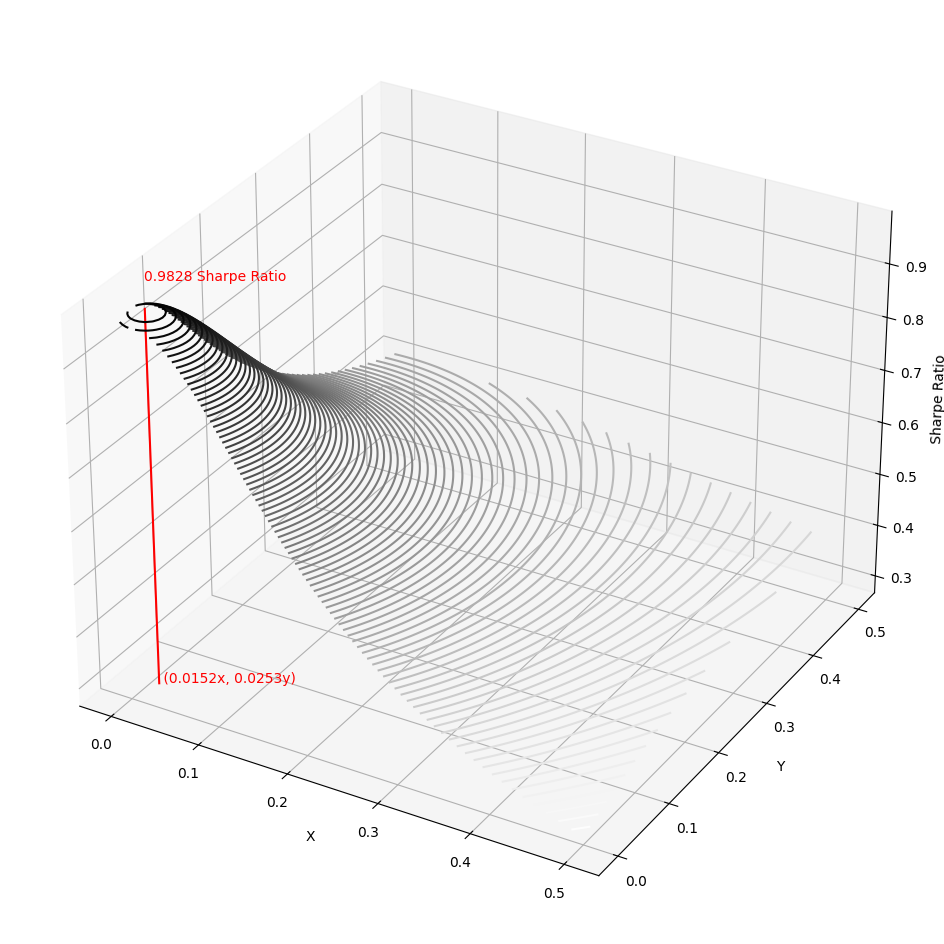

Pour n_bigcap =  1  et w_bigcap =  0.5

Best x: 0.015151515151515152
Best y: 0.025252525252525256

Delta Sharpe ratio: 0.9828347287398067

Portfolio Sharpe ratio: 0.20883487677975265
Indice Sharpe ratio: 0.0


In [455]:
import numpy as np
import plotly.graph_objects as go

# Univers :

ppc=0.6
ph=0.5
rh=1
rb=-1   
N_indice=100
n_bigcap=1
w_bigcap=0.5
N_ptf=30

# Surpondération 



import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Créer des listes pour x et y
x_values = w_bigcap * np.linspace(0, 1, 100)
y_values = w_bigcap * np.linspace(0, 1, 100)

# Créer une liste pour stocker les valeurs de Sharpe
sharpe_values = []

# Calculer le ratio de Sharpe pour chaque paire (x, y)
for y in x_values:
    for x in y_values:
        Esperance = delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        Variance = delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[1]
        sharpe = Esperance / np.sqrt(Variance)
        sharpe_values.append(sharpe)

# Convertir les listes en arrays numpy pour la visualisation
x_values, y_values = np.meshgrid(x_values, y_values)
sharpe_values = np.array(sharpe_values).reshape(x_values.shape)

"""# Créer un graphique 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_values, y_values, sharpe_values)"""

"""fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter(x_values, y_values, sharpe_values, c=sharpe_values, cmap='BrBG', linewidth=0.5)
"""

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.contour3D(x_values, y_values, sharpe_values, 100, cmap='binary')

# Find the index of the maximum Sharpe ratio
max_index = np.argmax(sharpe_values)
min_index = np.argmin(sharpe_values)

# Convert the index to 2D indices
max_indices = np.unravel_index(max_index, sharpe_values.shape)
min_indices = np.unravel_index(min_index, sharpe_values.shape)

# Find the corresponding x and y values
best_x = x_values[max_indices]
best_y = y_values[max_indices]
best_z = sharpe_values[max_indices]
worst_z = sharpe_values[min_indices]

max_z = np.max(sharpe_values)
min_z = np.min(sharpe_values)

ax.plot([best_x, best_x], [best_y, best_y], [min_z, max_z], color='red')


# Ajouter des titres aux axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Sharpe Ratio')

# Ajouter les valeurs de best_x et best_y sur les axes x et y
ax.text(best_x, best_y, min_z, f" ({best_x:.4f}x, {best_y:.4f}y)", color='red')
# Ajouter les valeurs de best_x et best_y sur les axes x et y
ax.text(best_x, best_y, max_z + 0.05, f"{max_z:.4f} Sharpe Ratio", color='red')

# Set the viewing angle
#ax.view_init(elev=5, azim=45)

# Afficher le graphique
plt.show()

# Find the index of the maximum Sharpe ratio
max_index = np.argmax(sharpe_values)

# Convert the index to 2D indices
max_indices = np.unravel_index(max_index, sharpe_values.shape)

# Find the corresponding x and y values
best_x = x_values[max_indices]
best_y = y_values[max_indices]

print("Pour n_bigcap = ", n_bigcap, " et w_bigcap = ", w_bigcap)

print("\nBest x:", best_x)
print("Best y:", best_y)

print("\nDelta Sharpe ratio:", sharpe_values[max_indices])

sharpe_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, best_x, best_y)[0] / np.sqrt(portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, best_x, best_y)[1])
sharpe_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, best_x, best_y, indice = True)[0] / np.sqrt(portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, best_x, best_y, indice = True)[1])

print("\nPortfolio Sharpe ratio:", sharpe_ptf)
print("Indice Sharpe ratio:", sharpe_indice)

<Axes: xlabel='Rendement Portefeuille', ylabel='Count'>

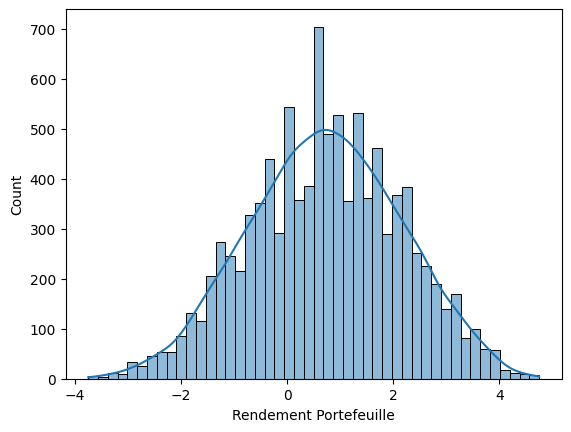

In [456]:
#Fais une distribution des rendements du portefeuille 
import seaborn as sns
sns.histplot(df['Rendement Portefeuille'], kde=True)

#Fais une distribution des rendements de l'indice


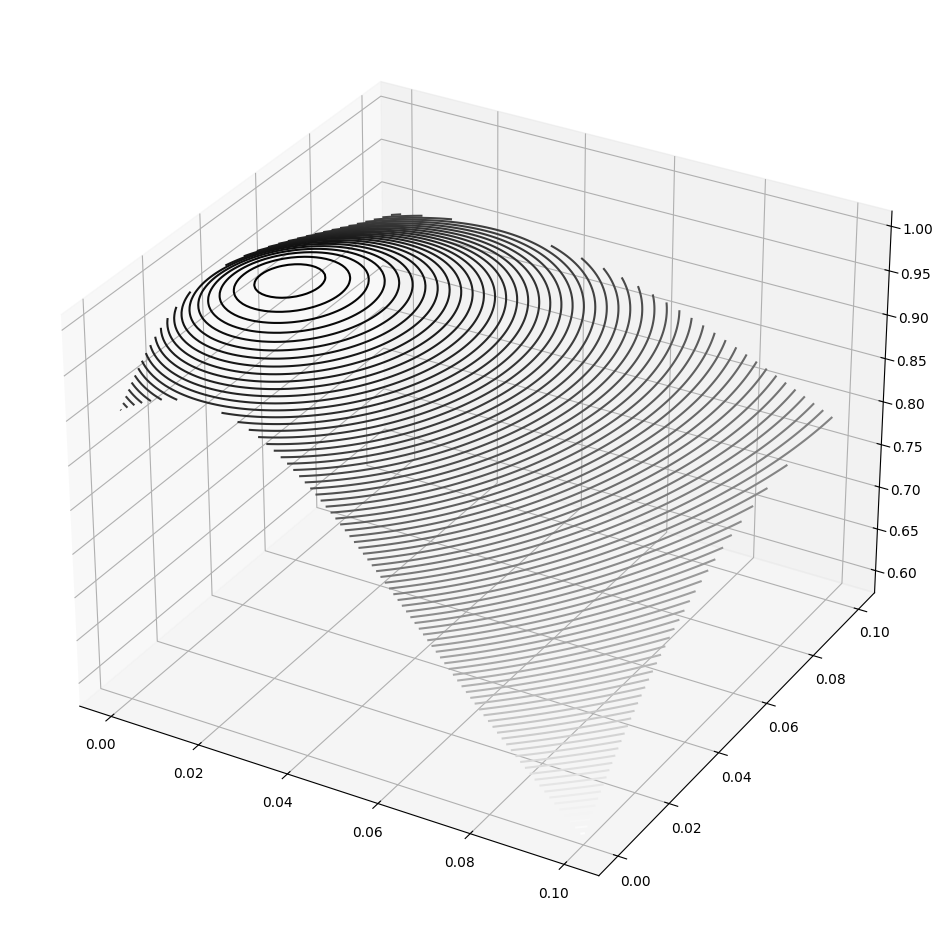

In [433]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.contour3D(x_values, y_values, sharpe_values, 100, cmap='binary')

In [369]:
ppc=0.6
ph=0.5
rh=1
rb=-1   
N_indice=100
n_bigcap=1
w_bigcap=0.5
N_ptf=30


###### Vérifier si la différence entre la simulation et la théorie est varie en fonction de x et y ######
for x in np.linspace(0, w_bigcap, 10):
    for y in np.linspace(0, w_bigcap, 10):
        print("Pour x = ", x, " et y = ", y)
        Esp, Var = delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, Precision = 1000)
        sharpe = Esp / np.sqrt(Var)

        EspFalse, VarFalse = delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)
        sharpeFalse = EspFalse / np.sqrt(VarFalse)

        print("Delta variance : ", np.sqrt(Var) - np.sqrt(VarFalse))
        print("Delta sharpe : ", sharpe - sharpeFalse)

print((df['Rendement Portefeuille'] - df['Rendement Indice']).var() - delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[1])

Pour x =  0.0  et y =  0.0
Delta variance :  -0.026762902398901445
Delta sharpe :  0.3337149791998266
Pour x =  0.0  et y =  0.05555555555555555
Delta variance :  -0.026424293854648936
Delta sharpe :  0.2844852714903404
Pour x =  0.0  et y =  0.1111111111111111
Delta variance :  -0.019669089673929885
Delta sharpe :  0.14539469624393775
Pour x =  0.0  et y =  0.16666666666666666
Delta variance :  -0.018659041570483592
Delta sharpe :  0.09827297753994779
Pour x =  0.0  et y =  0.2222222222222222
Delta variance :  -0.016410386118632825
Delta sharpe :  0.06295219893738502
Pour x =  0.0  et y =  0.2777777777777778
Delta variance :  -0.014075000124535386
Delta sharpe :  0.0409663339092029
Pour x =  0.0  et y =  0.3333333333333333
Delta variance :  -0.012414938151933563
Delta sharpe :  0.028534533885756552
Pour x =  0.0  et y =  0.38888888888888884
Delta variance :  -0.010663562967880569
Delta sharpe :  0.019947158821490896
Pour x =  0.0  et y =  0.4444444444444444
Delta variance :  -0.008544

In [292]:
import numpy as np
import plotly.graph_objects as go

# Univers :

ppc=0.6
ph=0.5
rh=1
rb=-1   
N_indice=100
n_bigcap=10
w_bigcap=0.01
N_ptf=30

# Surpondération 



import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Créer des listes pour x et y
x_values = w_bigcap * np.linspace(0, 1, 100)
y_values = w_bigcap * np.linspace(0, 1, 100)

# Créer une liste pour stocker les valeurs de Sharpe
sharpe_values = []
esperance_value = []
variance_value = []

# Calculer le ratio de Sharpe pour chaque paire (x, y)
for y in y_values:
    for x in x_values:
        Esperance = delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, Precision = 1000)[0]
        Variance = delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, Precision = 1000)[1]
        sharpe = Esperance / np.sqrt(Variance)
        sharpe_values.append(sharpe)
        #esperance_value.append(Esperance)
        #variance_value.append(Variance)

# Convertir les listes en arrays numpy pour la visualisation
x_values, y_values = np.meshgrid(x_values, y_values)
sharpe_values = np.array(sharpe_values).reshape(x_values.shape)
#esperance_value = np.array(esperance_value).reshape(x_values.shape)
#variance_value = np.array(variance_value).reshape(x_values.shape)

# Créer un graphique 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_values, y_values, sharpe_values)
#ax.plot_surface(x_values, y_values, esperance_value)
#ax.plot_surface(x_values, y_values, variance_value)

# Ajouter des titres aux axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Sharpe Ratio')

# Set the viewing angle
ax.view_init(elev=5, azim=45)

# Afficher le graphique
plt.show()

KeyboardInterrupt: 

In [384]:
from scipy.optimize import minimize


ppc=0.6
ph=0.5
rh=1
rb=-1   
N_indice=100
n_bigcap=5
w_bigcap=0.1
N_ptf=30

# Définir la fonction objective (négative du ratio de Sharpe)
def objective(params):
    x, y = params
    Esperance = delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, Precision = False)[0]
    Variance = delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, Precision = False)[1]
    sharpe = Esperance / np.sqrt(Variance)
    return -sharpe  # on minimise la fonction, donc on prend l'opposé du ratio de Sharpe

# Définir les contraintes
constraints = (
    {'type': 'ineq', 'fun': lambda x: 1 - n_bigcap * (w_bigcap + x[0])},  # n * (w_bigcap + x) ne doit pas dépasser 1
    {'type': 'ineq', 'fun': lambda x: n_bigcap * (w_bigcap - x[1])}  # n * (w_bigcap + x) ne doit pas dépasser 1
)
# Définir les bornes (si nécessaire)
bounds = [(0, 1), (0, 1)]
# Choisir des valeurs initiales pour x et y
initial_guess = [0.5, 0.5]

# Appeler le solveur
result = minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Afficher le résultat
print("Best x:", result.x[0])
print("Best y:", result.x[1])

delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, result.x[0], result.x[1], Precision = 1000)[0] / np.sqrt(delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, result.x[0], result.x[1], Precision = 1000)[1])

Best x: 0.019903013659653433
Best y: 0.02847934017245617


1.2068551316852643

In [403]:
esp, var = delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, result.x[0], result.x[1], Precision = 10000)
print(esp, var, esp/np.sqrt(var))


0.1284793401724561 0.010932952435270746 1.228752935035185


In [90]:
# Générèe 10000 chiffres aléatoire entre 0 et 1
n = 10000
x = np.random.rand(n)
y = np.random.rand(n)


AttributeError: 'list' object has no attribute 'ndim'

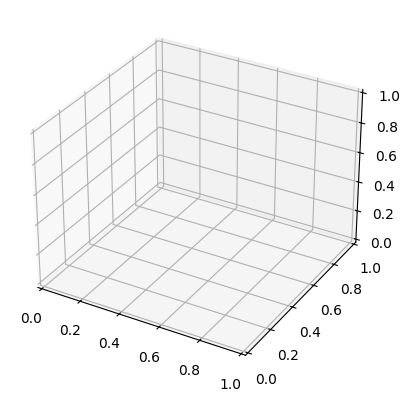

In [364]:
# Créer un graphique 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_values, y_values, sharpe_values)
#ax.plot_surface(x_values, y_values, esperance_value)
#ax.plot_surface(x_values, y_values, variance_value)

# Ajouter des titres aux axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Sharpe Ratio')

# Set the viewing angle
ax.view_init(elev=6, azim=-45)

# Afficher le graphique
plt.show()

In [88]:
# Find the index of the maximum Sharpe ratio
max_index = np.argmax(sharpe_values)

# Convert the index to 2D indices
max_indices = np.unravel_index(max_index, sharpe_values.shape)

# Find the corresponding x and y values
best_x = x_values[max_indices]
best_y = y_values[max_indices]

print("Pour n_bigcap = ", n_bigcap, " et w_bigcap = ", w_bigcap)

print("\nBest x:", best_x)
print("Best y:", best_y)
sharpe = delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, best_x, best_y)[0] / np.sqrt(delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, best_x, best_y)[1])
print(sharpe)
print("\nSharpe ratio:", sharpe_values[max_indices])

Pour n_bigcap =  3  et w_bigcap =  0.2

Best x: 0.01
Best y: 0.01
-0.18106847072179147

Sharpe ratio: 0.5200017472088058


In [632]:
ppc=0.6
ph=0.5
rh=1
rb=-1   
N_indice=100
n_bigcap=1
w_bigcap=0.5
N_ptf=30

x = 0.01
y = 0.5


sharpe = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0] / np.sqrt(portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[1])
print(sharpe)

0.5245500521593605


In [591]:
portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, 0, 0.1)


(0.19999999999999996, 0.04608000000000001)

In [550]:
ppc=0.6
ph=0.5
rh=1
rb=-1

N_indice=100
n_bigcap=1
w_bigcap=0.5
N_ptf=30

x=0.1
y=0.02

n_simulations = 10000
results = [simulate_portfolio(ppc = ppc, ph = ph, rh = rh, rb = rb, N_indice = N_indice, n_bigcap = n_bigcap, w_bigcap = w_bigcap, N_ptf = N_ptf, x = x, y = y) for _ in range(n_simulations)]

# Conversion des résultats en DataFrame
df = pd.DataFrame(results, columns=['Rendement Indice', 'Rendement Portefeuille','Poids','BigCap Portefeuille','SmallCap Portefeuille','BigCap Indice','SmallCap Indice','E_x_total', 'W_sc', 'E_WY'])    



In [516]:
print("Var simulée : ", (df['Rendement Portefeuille'] - df['Rendement Indice']).var())
print("E simulée : ", (df['Rendement Portefeuille'] - df['Rendement Indice']).mean())

sharpe = (df['Rendement Portefeuille'] - df['Rendement Indice']).mean() / np.sqrt((df['Rendement Portefeuille'] - df['Rendement Indice']).var())
sharpe_theorie = delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0] / np.sqrt(delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[1])
print("Sharpe simulé : ", sharpe)
print("Sharpe théorique : ", sharpe_theorie)

Var simulée :  0.028646229625795355
E simulée :  0.12224908631578946
Sharpe simulé :  0.7222904745210171
Sharpe théorique :  0.6727279802120993


(array([  1.,   1.,   0.,   1.,   2.,   1.,   1.,   1.,   1.,   2.,   0.,
          3.,   5.,   4.,   2.,   5.,   2.,  12.,  10.,  12.,  11.,  18.,
         19.,  15.,  24.,  25.,  21.,  29.,  36.,  34.,  48.,  60.,  63.,
         55.,  60.,  74.,  83.,  92.,  83., 102., 110., 118., 135., 131.,
        160., 173., 143., 179., 162., 213., 232., 208., 214., 212., 212.,
        223., 239., 223., 233., 242., 247., 262., 242., 263., 251., 221.,
        249., 244., 214., 246., 214., 206., 183., 203., 181., 161., 173.,
        156., 150., 121., 133., 127., 109.,  99., 110.,  82.,  72.,  73.,
         43.,  38.,  28.,  31.,  25.,  14.,  20.,  14.,   7.,   5.,   0.,
          3.]),
 array([-5.36842105e-01, -5.25894737e-01, -5.14947368e-01, -5.04000000e-01,
        -4.93052632e-01, -4.82105263e-01, -4.71157895e-01, -4.60210526e-01,
        -4.49263158e-01, -4.38315789e-01, -4.27368421e-01, -4.16421053e-01,
        -4.05473684e-01, -3.94526316e-01, -3.83578947e-01, -3.72631579e-01,
        -3.616

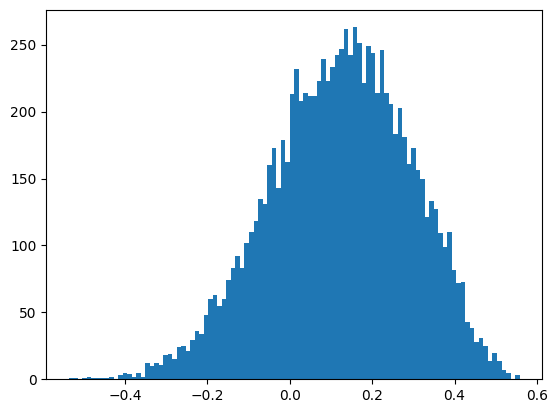

In [546]:
#Plot la distribution des rendements
plt.hist(df['Rendement Portefeuille'] - df['Rendement Indice'], bins=100)

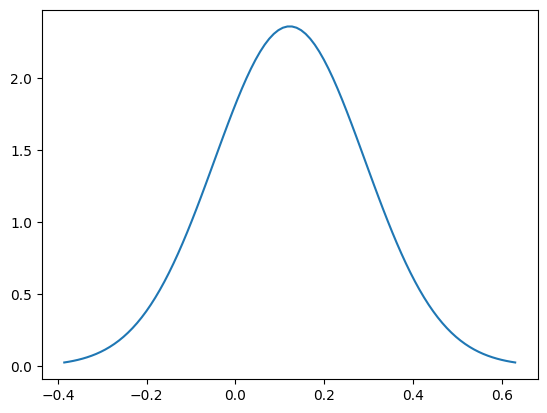

In [547]:
#Fais une loi normal avec E et Var
import scipy.stats as stats
import numpy as np

mu = (df['Rendement Portefeuille'] - df['Rendement Indice']).mean()
sigma = np.sqrt((df['Rendement Portefeuille'] - df['Rendement Indice']).var())

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.show()

ValueError: x and y can be no greater than 2D, but have shapes (100, 100, 100) and (100, 100, 100)

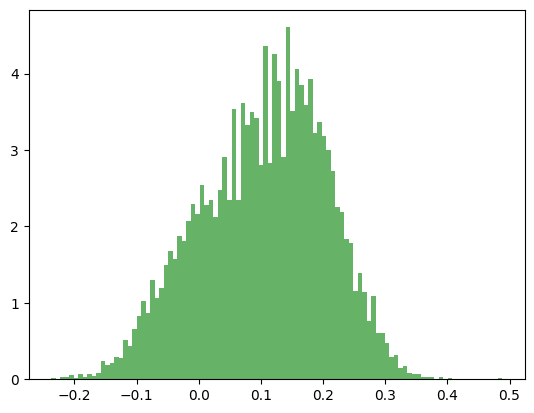

In [573]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Calculate mean and standard deviation
mu = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
sigma = np.sqrt(delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[1])

# Generate x values
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

# Plot the histogram of the data
plt.hist(df['Rendement Portefeuille'] - df['Rendement Indice'], bins=100, density=True, alpha=0.6, color='g')

# Plot the normal distribution
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='r')

# Show the plot
plt.show()

In [578]:
delta(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)

(array([[[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         ...,
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2]],
 
        [[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         ...,
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2]],
 
        [[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         ...,
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2]],
 
        ...,
 
        [[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
         [0.2,

In [554]:
# donne moi la probabilité que le portefeuille surperforme l'indice
1 - stats.norm.cdf(0, mu, sigma)

# Donne la probabilité que le df['Rendement Portefeuille'] - df['Rendement Indice'] soit supérieur à 0
df['delta'] = df['Rendement Portefeuille'] - df['Rendement Indice']

# Montre le nombre de fois ou delta est supérieur à 0
(df['delta'] > 0).sum() / len(df)

0.8275

On observe une espérance constante peu importe la valeur de x. Ca s'explique par un changement dans la contribution de l'espérance entre nos bigcap et nos smallcap. Plus x augmente, plus la contribution au rendement des BigCap est grande. Hors notre poche Big Cap est plus volatile que celle des SmallCap. Ca explique le ratio de sharpe le plus élevé soit pour x=0. Car on vient minimiser la contribution des BigCap à l'espérance, mais surtout à la variance.